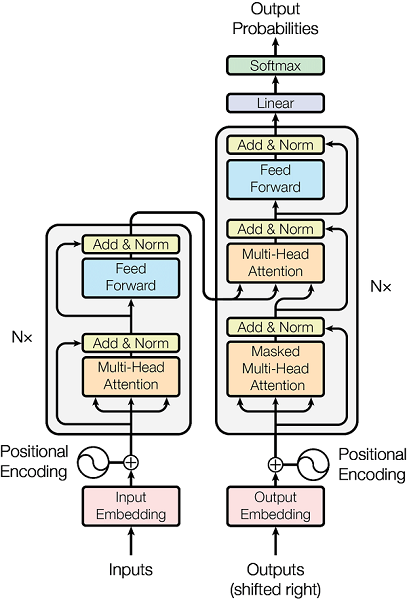

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore')

# Positional Encoding

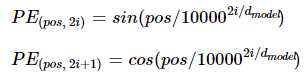

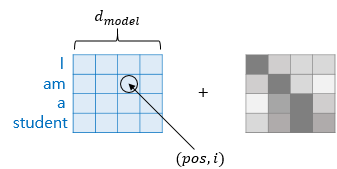

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model): # 시퀀스랑 차원
        super(PositionalEncoding, self).__init__() # 상속
        self.pos_encoding = self.positional_encoding(position, d_model) # positional_encoding ?

    def get_angles(self, position, i, d_model): # (위 이미지) 삼각함수 안에 들어갈 거
        angles = 1 / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32) ) 
        # tf.pow(a, b) = a**b / tf.cast: d_model를 tf.float32타입으로 변환
        return position * angles

    def positional_encoding(self, position, d_model):
        # 함수 안에 들어갈 거
        angle_rads = self.get_angles( position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                      i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                      d_model = d_model
        )
        # tf.range : 파이썬 range와 같이 생각
        # tf.newaxis : 차원추가

        sines = tf.math.sin(angle_rads[:, 0::2]) # 짝수 인덱스(2i) 에는 사인 함수
        cosines = tf.math.cos(angle_rads[:, 1::2]) # 홀수 인덱스(2i+1) 에는 코사인 함수
        # [시작인덱스::증가폭]

        angle_rads = np.zeros(angle_rads.shape) # 초기화(차원 크기만큼)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        # ... : 나머지 차원 전부

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)
    
    def get_config(self):
        config = super().get_config().copy() 
        config.update({
            'pos_encoding': self.pos_encoding
        })
        return config
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [3]:
a = tf.range(5)
print(a, '\n')
print(a[:, tf.newaxis], '\n')
print(a[tf.newaxis, :], '\n')

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32) 

tf.Tensor(
[[0]
 [1]
 [2]
 [3]
 [4]], shape=(5, 1), dtype=int32) 

tf.Tensor([[0 1 2 3 4]], shape=(1, 5), dtype=int32) 



(1, 50, 128)


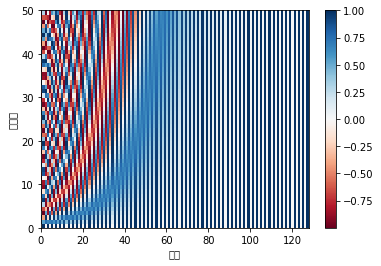

In [4]:
sample = PositionalEncoding(50, 128)

plt.pcolormesh(sample.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('차원')
plt.xlim((0, 128))
plt.ylabel('시퀀스')
plt.colorbar()
plt.show()

# Scaled Dot-Product Attention

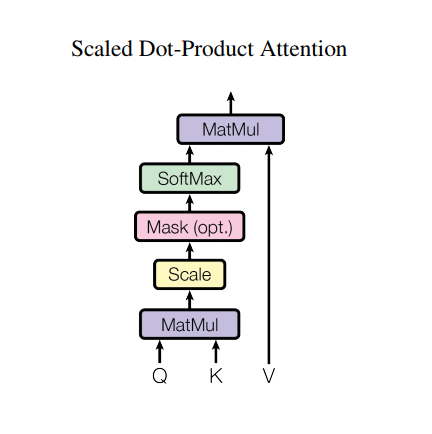

In [5]:
def scaled_dot_product_attention(query, key, value, mask):
    # MatMul
    matmul_qk = tf.matmul(query, key, transpose_b=True) # query 곱하기 key
    # transpose_b : b를 transpose할 것인지

    # Scale
    depth = tf.cast(tf.shape(key)[-1], tf.float32) # key의 마지막 차원
    logits = matmul_qk / tf.math.sqrt(depth) # depth = 차원을 헤더 갯수로 나눈 차원묶음

    # Mask(opt.) : attention에서 제외
    if mask is not None: # 값이 있으면
        logits += (mask * -1e9) # 아주 작은 값을 곱해준다

    # SoftMax
    attention_weight = tf.nn.softmax(logits, axis=-1)
    # (batch_size, num_heads, query의 문장 길이, key의 문장 길이)

    # Value와 MatMul
    output = tf.matmul(attention_weight, value)

    return output, attention_weight 

임의의 query, key, value 설정

In [6]:
np.set_printoptions(suppress=True)
# 소수점 표시(과학적 표기법 사용 억제)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
print('query', temp_q.shape)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)
print('key', temp_k.shape)

temp_v = tf.constant([[1, 0], 
                      [10, 0], 
                      [100, 5], 
                      [1000, 6]], dtype=tf.float32)
print('value', temp_v.shape)

query (1, 3)
key (4, 3)
value (4, 2)


In [7]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)

print(temp_out) # 어텐션값
print(temp_attn) # 어텐션 가중치

tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)


# Multihead Attention

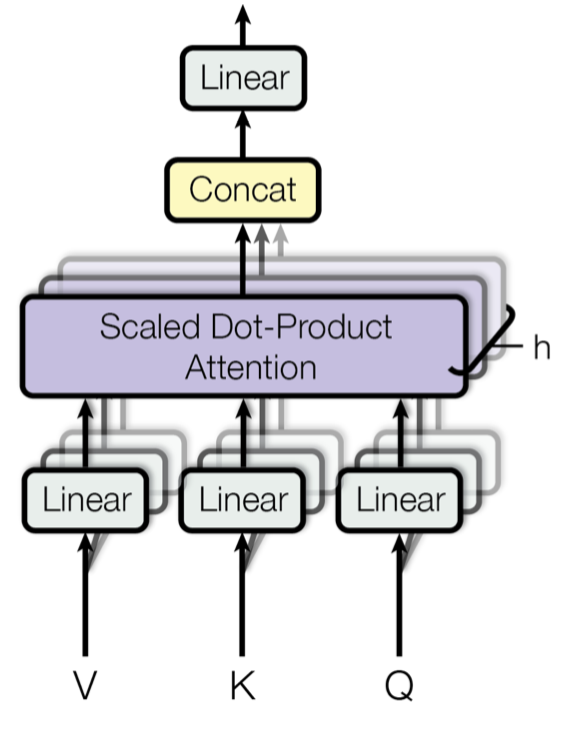

In [8]:
class MultiheadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiheadAttention, self).__init__(name=name)
        self.num_heads = num_heads # 헤드 갯수
        self.d_model = d_model # 차원

        assert d_model % self.num_heads == 0  # 차원이 헤드 갯수로 나눠 떨어져야 함

        self.depth = d_model // self.num_heads # 512 / 8 = 64
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)
        # 아웃풋의 차원을 d_model로 맞춰줌

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, 
                            shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
        # perm 에 따라 차원의 순서
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'depth': self.depth,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'dense': self.dense,
        })
        return config

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0] # query의 첫번째 차원

        # 1. 밀집층 지나기 (batch_size, sequence, dimension)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기 (batch_size, num_heads, sequence, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 어텐션
        # (batch_size, num_heads, sequence, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, sequence, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concat)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
        # 5. 밀집층
        outputs = self.dense(concat_attention)

        return outputs

In [9]:
# 옵션

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 sequence)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [10]:
test = tf.constant([[1, 21, 777, 0, 0]])
print(create_padding_mask(test))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


# 인코더

인코더 내부 레이어

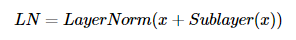

In [11]:
def encoder_layer(dff, d_model, num_heads, dropout, name='encoder_layer'):

    # 입력층
    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 1. 멀티헤드 어텐션(셀프)
    attention = MultiheadAttention(d_model, num_heads, name='attention')({'query': inputs, 'key':inputs, 'value':inputs, 'mask':padding_mask})
    #    드롭아웃, add + norm
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs+attention)

    # 2. Feed Forward
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    #    드롭아웃, add + norm
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention+outputs)

    # 모델링
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


인코더

In [12]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='encoder'):

    # 입력층
    inputs = tf.keras.Input(shape=(None, ), name='inputs')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # positional encoding, 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) # 단어벡터 * 차원의 제곱근
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 레이어 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff =dff, d_model=d_model, 
                                num_heads=num_heads, dropout=dropout,
                                name='encoder_layer_{}'.format(i),)([outputs, padding_mask])
        
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더

In [13]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    # upper triangle -> 0
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask) # 원소끼리 비교해서 큰 것

In [14]:
test = np.array([[1, 1, 1, 1],
                [1, 1, 1, 1],
                [1, 1, 1, 1], 
                [1, 1, 1, 1]])

1- tf.linalg.band_part(test, -1, 0)

<tf.Tensor: shape=(4, 4), dtype=int64, numpy=
array([[0, 1, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0]])>

In [15]:
test = tf.constant([[1, 21, 777, 0, 0]])
print(create_look_ahead_mask(test))
print(create_padding_mask(test))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [16]:
def decoder_layer(dff, d_model, num_heads, dropout, name='decoder_layer'):

    inputs = tf.keras.Input(shape=(None, d_model), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')


    # 마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')


    # 1. masked 멀티헤드 어텐션(셀프)
    attention1 = MultiheadAttention(d_model, num_heads, name='attention_1')(inputs={
                                                                            'query':inputs,
                                                                            'key':inputs,
                                                                            'value':inputs,
                                                                            'mask':look_ahead_mask
                                                                            })
    #    add + norm
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1+inputs)


    # 2. 멀티헤드 어텐션(decoder-encoder)
    attention2 = MultiheadAttention(d_model, num_heads, name='attention_2')(inputs={
                                                                            'query':attention1,
                                                                            'key':enc_outputs,
                                                                            'value':enc_outputs,
                                                                            'mask':padding_mask
                                                                            })
    #    드롭아웃, add + norm
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2+attention1)


    # 3. Feed Forward
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    #    드롭아웃, add + norm
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs+attention2)


    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)

In [17]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):

    inputs = tf.keras.Input(shape=(None, ), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name ='encoder_outputs')

    # 마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name ='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # positional encoding, 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 레이어 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, 
                                dropout=dropout, 
                                name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], 
                          outputs=outputs, name=name)

> 인코더 아웃풋 = 인코더 어텐션값?

> 마스크가 어떻게 사용되는지? (인코더 마스크, 디코더 마스크 ...)

> 첫번재 서브층에서 패드를 가린 채로 계산 -> 두번째 서브층에서 굳이 또 패드를 가린 채로 계산?

# 트랜스포머

In [18]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='transformer'):

    # 인코더 입력
    inputs = tf.keras.Input(shape=(None, ), name='inputs')

    # 디코더 입력
    dec_inputs = tf.keras.Input(shape=(None, ), name = 'dec_inputs')

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, 
                                              output_shape=(1, 1, None),
                                              name = 'enc_padding_mask')(inputs)
    
    # 디코더 룩어헤드 마스크 (첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                             output_shape=(1, None, None),
                                             name = 'look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크 (두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                              output_shape=(1, 1, None),
                                              name = 'dec_padding_mask')(inputs)
    
    # enc_outputs(인코더에서 나온 출력)이 디코더로 전달된다
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model,
                          num_heads=num_heads, dropout=dropout,)(inputs=[inputs, enc_padding_mask])
    # 인코더의 입력은 입력문장(inputs)과 패딩마스크(enc_padding_mask)

    # dec_outputs(디코더에서 나온 출력)이 출력층으로 전달된다
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model,
                          num_heads=num_heads, dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 출력층(다음 단어 예측)
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

손실함수

In [19]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH-1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                         reduction = 'none')(y_true, y_pred)
                                                        

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

학습률

In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def get_config(self):
        config = {
            'd_model': self.d_model,
            'warmup_steps': self.warmup_steps,

             }
        return config
        
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step) # 역제곱??
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'step')

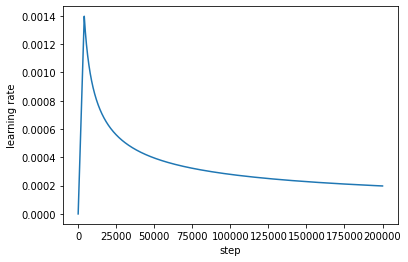

In [21]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel('learning rate')
plt.xlabel('step')


-----------------------

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [26]:
train_data = pd.read_csv('/content/final_data.csv', index_col=[0])
train_data.head()

,Q,A
0,1시간에 얼마인가요?,처음 1시간은 1000원이고 이후 1시간은 500원씩 추가됩니다
1,무인발급기 있나요?,무인발급기는 카운터 바로 옆쪽에 이용 가능합니다
2,1달 정액권 끊을 수 있나요?,네 1달에 5만 원입니다
3,정액권 끊다가 정지해도 되나요?,네 가능합니다
4,음식 주문 가능한가요?,햄버거랑 핫도그 종류 가능합니다


In [27]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 45428


In [28]:
train_data.dropna(inplace=True)
print(train_data.isnull().sum())

Q    0
A    0
dtype: int64


In [29]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [30]:
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [31]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**15)

In [32]:
tokenizer.subwords[:100]

[' ?',
 '네_',
 ' ,  ',
 '네',
 '있어요',
 ' .',
 '이_',
 '한_',
 '있나요',
 '그_',
 '수_',
 '좀_',
 '주세요',
 '몇_',
 '지금_',
 '다_',
 '돼요',
 '예_',
 '어떻게_',
 '있습니다',
 '아_',
 '거_',
 '여기_',
 ' .  ',
 '안_',
 '는_',
 '혹시_',
 '도_',
 '그럼_',
 '선생님_',
 '되나요',
 '요',
 '정도_',
 '해요',
 '더_',
 '어떤_',
 '은_',
 '있는_',
 '많이_',
 '만_',
 '두_',
 '됩니다',
 '게_',
 '제가_',
 '없어요',
 '하나_',
 '하고_',
 '에_',
 '잘_',
 '거예요',
 '가능한가요',
 '따로_',
 '가_',
 '입니다',
 '고_',
 '가능합니다',
 '원이에요',
 '그러면_',
 '건_',
 '이거_',
 '뭐_',
 '얼마에요',
 '을_',
 '다른_',
 '예',
 '원_',
 '얼마예요',
 '같은_',
 ' ?  ',
 '저_',
 '로_',
 '이런_',
 '으로_',
 '조금_',
 '같이_',
 '번_',
 '하면_',
 '면_',
 '드릴게요',
 '이거는_',
 '\xa0',
 '저희_',
 '에요',
 '드릴까요',
 '그리고_',
 '할_',
 '바로_',
 '해_',
 '를_',
 '랑_',
 '저희가_',
 '가지고_',
 '하나요',
 '것_',
 '어느_',
 '얼마인가요',
 '가격이_',
 '원입니다',
 '차량_',
 '요_']

In [33]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [34]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [30469]
종료 토큰 번호 : [30470]
단어 집합의 크기 : 30471


In [35]:
# EDA

test_tokens_Q, test_tokens_A = [], []

for (sentence1, sentence2) in zip(questions, answers):
    sentence1 = tokenizer.encode(sentence1) 
    sentence2 = tokenizer.encode(sentence2)

    test_tokens_Q.append(sentence1)
    test_tokens_A.append(sentence2)

In [36]:
length_Q = [len(t) for t in test_tokens_Q]
length_A = [len(t) for t in test_tokens_A]
length_QA = length_A + length_Q

print('문장 최대 길이 : {}'.format(np.max(length_QA)))
print('문장 최소 길이 : {}'.format(np.min(length_QA)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(length_QA)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(length_QA)))
print('문장 중간 길이 : {}'.format(np.median(length_QA)))

문장 최대 길이 : 146
문장 최소 길이 : 1
문장 평균 길이 : 6.41
문장 길이 표준편차 : 5.74
문장 중간 길이 : 5.0


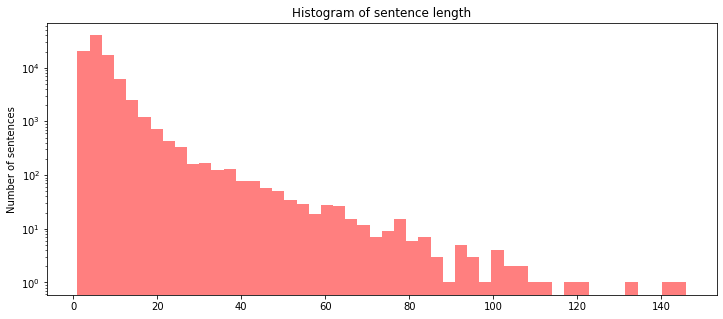

In [37]:
plt.figure(figsize=(12,5))
plt.hist(length_QA, bins=50, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Histogram of sentence length')
plt.ylabel('Number of sentences')
plt.show()

In [38]:
# 80~100 정도가 적당하다고 생각

MAX_LENGTH = 90

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

**추가할 것 checkpoint, early stopping, train/test/validation**

In [39]:
questions, answers = tokenize_and_filter(questions, answers)

In [40]:
X_train, X_eval, y_train, y_eval = train_test_split(questions, answers, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_eval, y_eval, random_state=42)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(34066, 90) (34066, 90)
(8517, 90) (8517, 90)
(2839, 90) (2839, 90)


In [41]:
BATCH_SIZE = 128
BUFFER_SIZE = 50000

dataset = tf.data.Dataset.from_tensor_slices(( { 'inputs' : X_train,
                                                 'dec_inputs' : y_train[:, :-1]}, # 마지막 토큰 제거
                                               { 'outputs': y_train[:, 1:] } # 첫번째 토큰 제거
                                               ))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [42]:
BATCH_SIZE = 128
BUFFER_SIZE = 50000

dataset_valid = tf.data.Dataset.from_tensor_slices(( { 'inputs' : X_valid,
                                                 'dec_inputs' : y_valid[:, :-1]}, # 마지막 토큰 제거
                                               { 'outputs': y_valid[:, 1:] } # 첫번째 토큰 제거
                                               ))

dataset_valid = dataset_valid.cache()
dataset_valid = dataset_valid.shuffle(BUFFER_SIZE)
dataset_valid = dataset_valid.batch(BATCH_SIZE)
dataset_valid = dataset_valid.prefetch(tf.data.experimental.AUTOTUNE)

In [43]:
BATCH_SIZE = 128
BUFFER_SIZE = 50000

dataset_test = tf.data.Dataset.from_tensor_slices(( { 'inputs' : X_test,
                                                 'dec_inputs' : y_test[:, :-1]}, # 마지막 토큰 제거
                                               { 'outputs': y_test[:, 1:] } # 첫번째 토큰 제거
                                               ))

dataset_test = dataset_test.cache()
dataset_test = dataset_test.shuffle(BUFFER_SIZE)
dataset_test = dataset_test.batch(BATCH_SIZE)
dataset_test = dataset_test.prefetch(tf.data.experimental.AUTOTUNE)

## checkpoint & early stopping

In [44]:
tf.keras.backend.clear_session() # 노트북 세션 리셋

# 하이퍼파라미터
D_MODEL = 512
NUM_LAYERS = 4
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(vocab_size = VOCAB_SIZE, 
                    num_layers=NUM_LAYERS, 
                    dff=DFF, 
                    d_model=D_MODEL,
                    num_heads = NUM_HEADS,
                    dropout=DROPOUT)

# (새로운 차원, 단어 집합의 크기, 임베딩 차원)

(1, 30471, 512)
(1, 30471, 512)


In [48]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) # 라벨의 크기 맞춰주기
    return tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)) # one-hot encoding 안 되어 있을 때

#     mask = tf.math.logical_not(tf.math.equal(y_true, 0))
#     mask = tf.expand_dims(tf.cast(mask, dtype=y_pred.dtype), axis=-1)
#     y_pred *= mask    
#     acc = tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

#     return tf.reduce_mean(acc)



In [49]:
# 모델 컴파일

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_SAVE_FOLDER_PATH = './models/'

model_path = MODEL_SAVE_FOLDER_PATH + 'chatbot-' + '{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=4)

# dense레이어

In [ ]:
EPOCHS = 200
model.fit(dataset,
          validation_data=dataset_valid, 
          epochs=EPOCHS, 
          callbacks=[cb_checkpoint, cb_early_stopping])

In [46]:
model.load_weights('/content/chatbot-08-0.5025.hdf5')

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model('./models/') # 베스트 모델 입력하기

In [50]:
loss, acc = model.evaluate(dataset_test, verbose=2)
print('베스트 모델의 성능: {:5.2f}%'.format(100*acc))

23/23 - 12s - loss: 0.4941 - accuracy: 0.0215
베스트 모델의 성능:  2.15%


In [51]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence)+END_TOKEN, axis=0)
    # tf.expand_dims : 크기 1인 차원을 shape의 n번째에 삽입

    output = tf.expand_dims(START_TOKEN, 0)
    # SHAPE [1, 1]

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재 시점의 예측 단어를 받아온다
        predictions = predictions[:, -1:, :] 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32) # 최대값의 인덱스

        # 종료 토큰이면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측 단어 출력에 연결
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0) # 차원 축소

In [52]:
def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    # print('Input : {}'.format(sentence))
    # print('Output : {}'.format(predicted_sentence))

    return predicted_sentence

In [53]:
def preprocess_sentence(sentence):
    sentence = re.sub(r'([?.!,])', r' \1', sentence) # ?.!, 앞에 띄어쓰기
    sentence = sentence.strip() # 문장 앞뒤 공백 제거
    return sentence

In [127]:
predict('배달 가능 지역')

'네 가능합니다'

In [ ]:
# 영업시간이 어떻게 돼요?
# 배달 몇시까지 해요?
# 오늘이 강의 마지막 날이야

# 텔레그램 연동하기

In [131]:
!pip install python-telegram-bot

     |████████████████████████████████| 450kB 17.3MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 


In [135]:
# 봇 빌더 실행 -> token 받음 -> 밑 코드 실행시 고유id 부여

import telegram

token = "토큰을 입력하세요"

bot = telegram.Bot(token = token)

updates = bot.getUpdates()

print(updates)

for i in updates:
    print(i)

print('start telegram chat bot')

# eastweat_chatbot
# 1609466974

[<telegram.update.Update object at 0x7f84e3564610>, <telegram.update.Update object at 0x7f84e35641d0>]
{'update_id': 754117056, 'message': {'message_id': 1, 'date': 1617762997, 'chat': {'id': 1609466974, 'type': 'private', 'first_name': 'Yunsoo', 'last_name': 'Woo'}, 'text': '/start', 'entities': [{'type': 'bot_command', 'offset': 0, 'length': 6}], 'caption_entities': [], 'photo': [], 'new_chat_members': [], 'new_chat_photo': [], 'delete_chat_photo': False, 'group_chat_created': False, 'supergroup_chat_created': False, 'channel_chat_created': False, 'from': {'id': 1609466974, 'first_name': 'Yunsoo', 'is_bot': False, 'last_name': 'Woo', 'language_code': 'ko'}}}
{'update_id': 754117057, 'message': {'message_id': 2, 'date': 1617762999, 'chat': {'id': 1609466974, 'type': 'private', 'first_name': 'Yunsoo', 'last_name': 'Woo'}, 'text': 'ㅎㅇ', 'entities': [], 'caption_entities': [], 'photo': [], 'new_chat_members': [], 'new_chat_photo': [], 'delete_chat_photo': False, 'group_chat_created': Fal

In [136]:
bot = telegram.Bot(token)
bot.sendMessage(chat_id=1609466974, text="테스트 해보겠습니다")

In [138]:
from telegram.ext import Updater
from telegram.ext import CommandHandler

# updater 
updater = Updater(token=token, use_context=True)
dispatcher = updater.dispatcher

# command hander
def start(update, context):
    context.bot.send_message(chat_id=update.effective_chat.id, text="저는 동문서답으로 대답하는 봇입니다")

start_handler = CommandHandler('start', start)
dispatcher.add_handler(start_handler)

# polling
updater.start_polling()

In [139]:
from telegram.ext import MessageHandler, Filters

# updater 
updater = Updater(token=token, use_context=True)
dispatcher = updater.dispatcher

# message handler
def mymodel(update, context):
    user_id = update.effective_chat.id
    user_text = update.message.text
    text = predict(user_text)
    context.bot.send_message(chat_id=user_id, text=text)

echo_handler = MessageHandler(Filters.text & (~Filters.command), mymodel)
dispatcher.add_handler(echo_handler)

# polling
updater.start_polling()

ERROR:telegram.ext.updater:Error while getting Updates: Conflict: terminated by other getUpdates request; make sure that only one bot instance is running
ERROR:telegram.ext.dispatcher:No error handlers are registered, logging exception.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/telegram/ext/updater.py", line 516, in _network_loop_retry
    if not action_cb():
  File "/usr/local/lib/python3.7/dist-packages/telegram/ext/updater.py", line 471, in polling_action_cb
    allowed_updates=allowed_updates,
  File "/usr/local/lib/python3.7/dist-packages/telegram/bot.py", line 127, in decorator
    result = func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/telegram/bot.py", line 2762, in get_updates
    'getUpdates', data, timeout=float(read_latency) + float(timeout), api_kwargs=api_kwargs
  File "/usr/local/lib/python3.7/dist-packages/telegram/bot.py", line 260, in _post
    f'{self.base_url}/{endpoint}', data=data, timeout=effective_tim